## Imports

In [1]:
%pip install pinecone-client datasets PyTDC rdkit datamol pandas numpy molfeat mols2grid tensorflow molecule_generation safe-mol


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tdc.generation import MolGen
from pinecone import Pinecone, ServerlessSpec
import datamol as dm
from datamol.similarity import cdist
import molfeat
from molfeat.calc import FPCalculator, RDKitDescriptors2D
from molfeat.trans import MoleculeTransformer
from molfeat.store.modelstore import ModelStore
from molfeat.trans.pretrained import PretrainedMolTransformer, GraphormerTransformer
import mols2grid
import rdkit
from rdkit import Chem
import tensorflow as tf
import safe as sf

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

import sqlite3

## Load data

In [4]:
from tdc.generation import MolGen
data = MolGen(name = 'ZINC')
split = data.get_split() 

Found local copy...
Loading...
Done!


## SQL database (in the future)

In [14]:
con = sqlite3.connect('molsearch.db')

In [15]:
cur = con.cursor()

In [16]:
cur.execute("CREATE TABLE molecules(ID, SMILES)")

In [18]:
split['test'].iloc[:100]

,smiles
0,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1
3,C=CCc1ccccc1OC(C)=O
4,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)c1
...,...
95,Cc1cc(NC(=O)CNC(=O)[C@@H]2CCC(=O)N2)no1
96,CSc1ccc(Cl)cc1NCC(=O)NCc1ccco1
97,COc1cccc(C(=O)NCC(=O)Nc2ccc(Cl)cc2)c1F
98,N#Cc1cc(Cl)nc(NNC(=O)CCNc2ccccc2[N+](=O)[O-])c1


## Generate test set
(novel molecules similar to fentanyl)

In [29]:
def compute_tanimoto(mol1, mol2):
    mol1 = Chem.MolFromSmiles(mol1)
    mol2 = Chem.MolFromSmiles(mol2)
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]

In [7]:
# Function to run unconditional generation from a single SMILES
def gen_mol(smiles, coati_version = 1, num_variations = 100, noise_scale = 0.15):

    # Embed the SMILES
    smiles = Chem.CanonSmiles(smiles)
    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale,
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

In [8]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    # device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl",
)

Loading model from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
Loading tokenizer may from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
22235904 params frozen!


reference molecule:


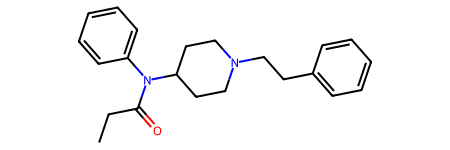

Generated molecules (noise std=0.35):


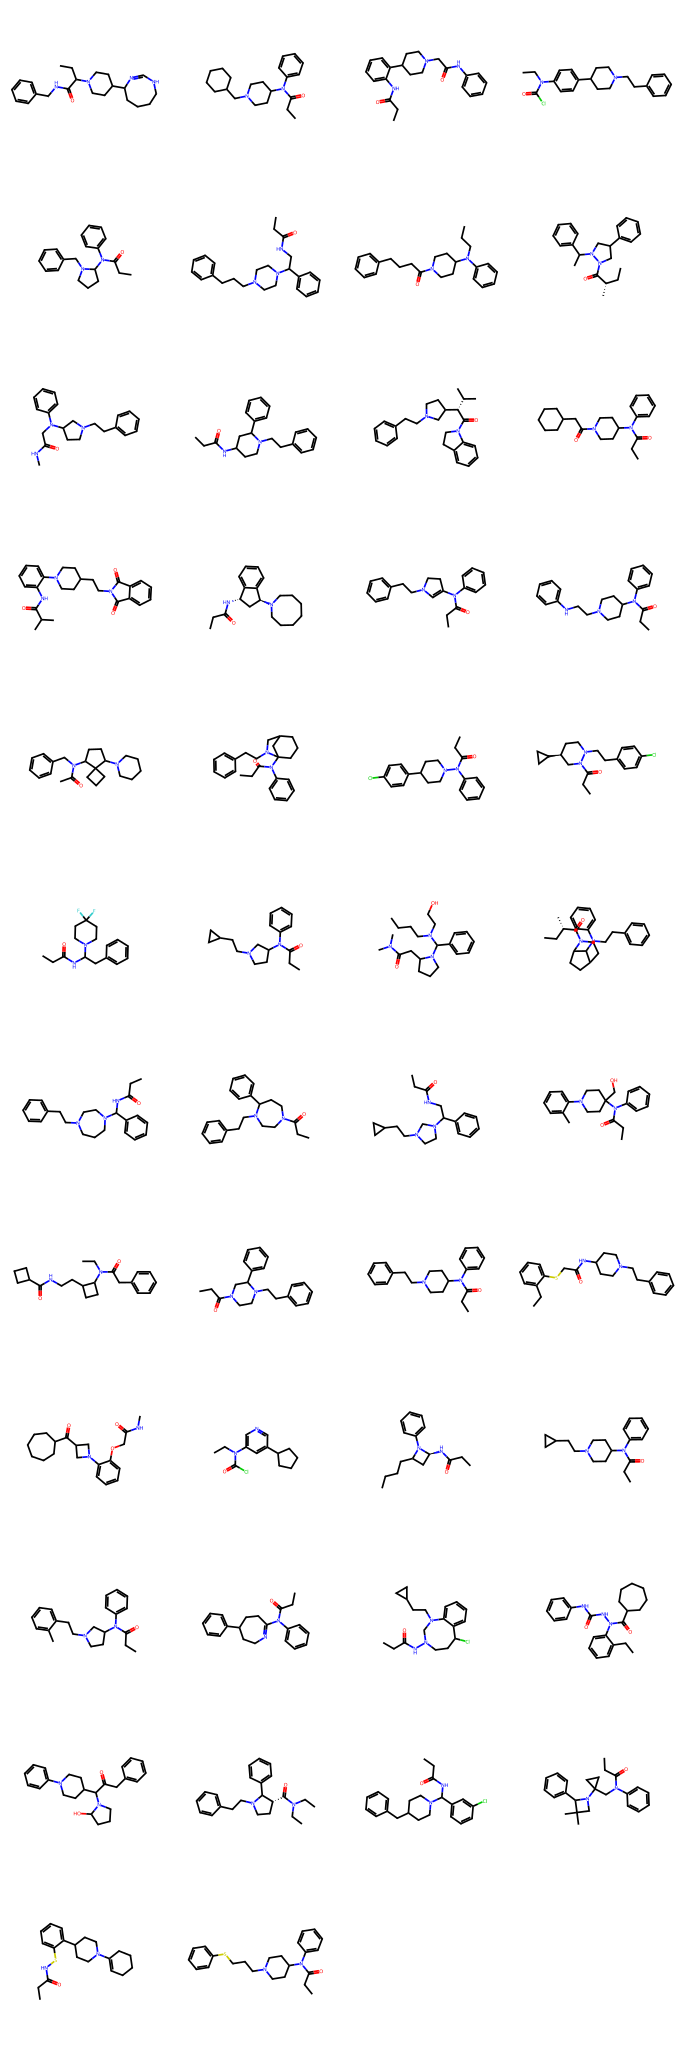

In [10]:
from coati.generative.coati_purifications import embed_smiles

# In this example, we use fentanyl as a reference molecule.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))

# We first convert the smiles to canonical smiles which is required by the model.
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))
# We then embed the canonical smiles to a 256D vector using the model.
fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

# We then generate 30 molecules near fentanyl. We do this by adding noise to the
# embedding vector which is then injected into the embed token in the prefix.
# The generated molecules are decoded back to smiles.
num_variations = 100
# noise is added as an isotropic Gaussian with std=noise_scale.
noise_scale = 0.35
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.35,
)

# Visualize the generated molecules.
# Note that generated molecules are not guaranteed to be valid.
# Here we also use the set() function to remove duplicates.
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

In [12]:
valid_smiles = [s for s in set(smiles_near_fentanyl) if not Chem.MolFromSmiles(s) is None]

In [13]:
len(valid_smiles)

46

In [ ]:
valid_df = pd.DataFrame()

valid_df['smiles'] = valid_smiles

## Featurize

In [20]:
mols_fentanyl = dm.convert.from_df(valid_df)

In [27]:
mols_zinc = dm.convert.from_df(split['test'].iloc[:100])

In [32]:
df_fent = dm.descriptors.batch_compute_many_descriptors(mols_fentanyl, properties_fn=None, add_properties=True, n_jobs=-1, batch_size='auto', progress=False, progress_leave=True)

In [35]:
df_fent['mols'] = mols_fentanyl

In [42]:
df_fent['mol_id'] = [f'Fentanyl_Gen {i + 1}' for i, _ in enumerate(df_fent.mw)]

In [37]:
df_zinc = dm.descriptors.batch_compute_many_descriptors(mols_zinc, properties_fn=None, add_properties=True, n_jobs=-1, batch_size='auto', progress=False, progress_leave=True)

In [38]:
df_zinc['mols'] = mols_zinc

In [43]:
df_zinc['mol_id'] = [f'ZINC {i + 1}' for i, _ in enumerate(df_zinc.mw)]

In [45]:
# featurizer = GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)
featurizer = PretrainedMolTransformer(kind='ChemGPT-1.2B', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)

In [46]:
# calc = FPCalculator("ecfp")
calc = RDKitDescriptors2D(replace_nan=True)

In [53]:
featurizer = MoleculeTransformer(calc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = np.stack(featurizer(mols_fentanyl))

feats.shape

(46, 216)

In [58]:
featurizer = MoleculeTransformer(calc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = np.stack(featurizer(mols_zinc))

feats.shape

(100, 216)

## Configure Pinecone index

In [48]:
pc = Pinecone(api_key= "c2c9ba1d-9710-472b-a950-a3db5b40a67c") ## supplied by Pinecone

In [49]:
index = pc.Index('molsearch') ## already created

### Upsert vectors

In [ ]:
id_list = [f'Fentanyl_Gen {i + 1}' for i, _ in enumerate(feats)]
id_list = [f'ZINC {i + 1}' for i, _ in enumerate(feats)]

In [60]:
payload = zip(id_list, feats)

In [56]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [61]:
for ids_vectors_chunk in chunks(payload, batch_size=10):
    index.upsert(vectors=ids_vectors_chunk) 

## Similarity search

In [ ]:
## Using fentanyl as query

In [62]:
with dm.without_rdkit_log():
    feats = np.stack(featurizer(Chem.MolFromSmiles(fentanyl_canonical_smiles)))


In [63]:
query_results = index.query(vector = feats.tolist()[0], top_k = 100)

In [64]:
result_id = [query_results['matches'][id_no]['id'] for id_no in range(len(query_results['matches'])) ]

## Analyze hit similarity

In [ ]:
## Can estimate precision (> Tanimoto threshold in the returned set)
## Recall (Tanimoto for all in the dataset and see if retrieved top 100)
## Tanimoto as ground truth here


In [67]:
def compute_tanimoto(mol1, mol2):
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]
    

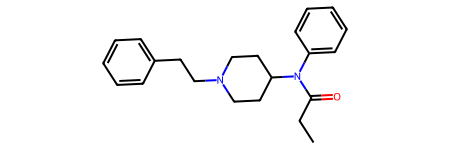

In [68]:
Chem.MolFromSmiles(fentanyl_canonical_smiles)

In [71]:
df = pd.concat([df_fent,df_zinc])

In [73]:
df_results = df[df['mol_id'].isin(result_id)]

In [74]:
df_results['tanimoto'] = df_results['mols'].apply(compute_tanimoto, args= (Chem.MolFromSmiles(fentanyl_canonical_smiles), ))

In [90]:
df_results = df_results.sort_values(by = 'tanimoto', ascending = False)

In [76]:
mols2grid.display(df_results, mol_col = 'mols', subset = ['mol_id', 'img', 'tanimoto'])

MolGridWidget()

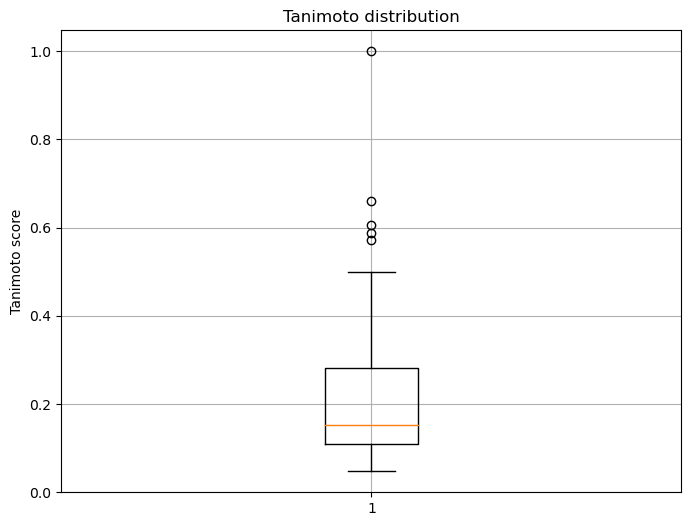

In [89]:
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_results['tanimoto'])
plt.title('Tanimoto distribution')
plt.ylabel('Tanimoto score')
plt.grid(True)
plt.show()